In [1]:
import numpy as np
import pandas as pd
import os
from fastai.data.all import *
from fastai.vision.all import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
paths_list = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths_list.append(os.path.join(dirname, filename))

In [3]:
def  npy_load(path, pad=1374):
    result = np.zeros((pad,80))
    try:
        matrix = np.load(path)
        result[:matrix.shape[0],:matrix.shape[1]] = matrix
        return result 
    except ValueError:
        return result 

In [4]:
%%time
paths_df = pd.DataFrame({'paths':paths_list})
paths_df['set'] = ['train' if x==-1 else 'val' for x in paths_df.paths.str.find('val')]
paths_df['is_noise'] = [1 if x==-1 else 0 for x in paths_df.paths.str.find('clean')]
paths_df['speaker_id'] = paths_df.paths.str.findall(r'\/\d*\/').str[0].str[1:-1]
paths_df['filename'] = paths_df.paths.str.findall(r'[\d\-_]*\.npy').str[0]
#paths_df['npy'] = paths_df.paths.apply(npy_load)

CPU times: user 268 ms, sys: 7.87 ms, total: 276 ms
Wall time: 283 ms


In [5]:
def get_files(_, _set = 'train'):
    result = list(paths_df[paths_df['set'] == _set].filename.unique())
    return result 

In [6]:
def get_matrix(filename):
    path = paths_df[(paths_df['filename'] == filename)&(paths_df['is_noise']==1)].paths.values[0]
    result = npy_load(path)
    return result

In [7]:
def get_label(filename):
    path = paths_df[(paths_df['filename'] == filename)&(paths_df['is_noise']==0)].paths.values[0]
    result = npy_load(path)
    return result

In [8]:
dblock = DataBlock(blocks    = (ImageBlock, ImageBlock),
                   get_items = get_files,
                   get_x     = get_matrix, 
                   get_y     = get_label,
                   splitter  = RandomSplitter()
                  )

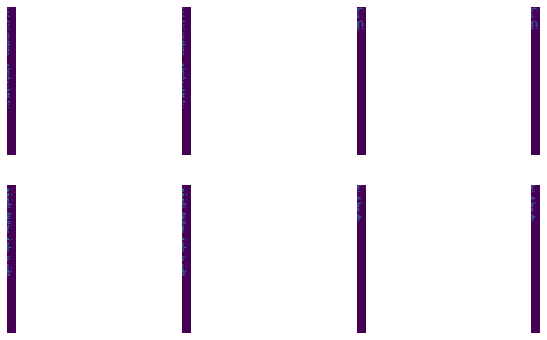

In [9]:
dls = dblock.dataloaders(Path(''), bs=4)
dls.show_batch()

In [10]:
learn = unet_learner(dls, models.resnet18, loss_func=nn.MSELoss(), n_out=1)
learn.fit_one_cycle(1, slice(1e-5, 0.01/5))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,time
0,0.017626,0.017625,09:02


In [11]:
learn.save("model_unetresnet18")

Path('models/model_unetresnet18.pth')

In [12]:
def get_files_val(_, _set = 'val'):
    result = list(paths_df[paths_df['set'] == _set].filename.unique())
    return result 

In [13]:
dblock_val = DataBlock(blocks    = (ImageBlock, ImageBlock),
                   get_items = get_files_val,
                   get_x     = get_matrix, 
                   get_y     = get_label,
                   splitter  = RandomSplitter(valid_pct=0.8)
                  )

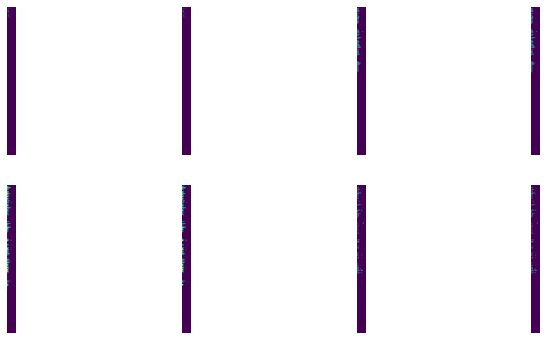

In [14]:
dls_val = dblock_val.dataloaders(Path(''), bs=4)
dls_val.show_batch()

In [15]:
learn_val = unet_learner(dls_val, models.resnet18, loss_func=nn.MSELoss(), n_out=1)

In [16]:
learn_val.load("model_unetresnet18")

In [17]:
learn_val.validate()

(#1) [0.01762499287724495]